In [1]:
%cd ../
%pwd

D:\Projects\IndiaTB\IndTB_ppa


'D:\\Projects\\IndiaTB\\IndTB_ppa'

In [2]:
import pandas as pd
import numpy as np
from ppa.rates import *
from ppa.shifting import *
import matplotlib.pyplot as plt
import sims_pars as spr
from sims_pars.fitting import ApproxBayesComSMC
from scipy.optimize import minimize
from scipy import linalg

In [3]:
bn = get_prior()

dat = pd.read_csv('data/cascade/d_cascade_2019.csv').set_index('State')
dat = {i: row.to_dict() for i, row in dat.iterrows()}
dat = dat['Tamil Nadu']

p0 = spr.sample(bn)

cas = Rates(dat, p0)

for k, v in cas.to_json().items():
    print(k, v)

R_Succ_Tx [2.         2.         1.33771156]
R_LTFU_Tx [0.11764706 0.04878049 0.04894067]
R_Die_Tx [0.11764706 0.02439024 0.01631356]
R_SelfCure 0.23553772354623928
R_Die_Asym 0.156043448206434
R_Die_Sym 0.17727552225386958
R_Onset 4.490479964509301
R_Aware 4.466703692592948
R_CSI 42.09923505651007
R_Det 9.109632778886672
PPV [0.85       0.85       0.54289344]


In [4]:
alg = ApproxBayesComSMC(max_round=40, n_collect=200, n_core=4, verbose=8)

In [5]:
obj = ObjRates(dat)

alg.fit(obj)

02-06-2022 17:21:24 INFO: Initialising
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done  38 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 152 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 193 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.6s finished
02-06-2022 17:21:28 INFO: Step to 1
02-06-2022 17:21:28 INFO: Round 0, ESS 200.00
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.1s finished
02-06-2022 17:21:31 INFO: Step to 2
02-06-2022 17:21:31 INFO: Round 1, ESS 180, Epsilon 10.1922, Acceptance 90.5%
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tas

[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.4s finished
02-06-2022 17:22:27 INFO: Step to 22
02-06-2022 17:22:27 INFO: Round 21, ESS 200, Epsilon -5.8644, Acceptance 52.0%
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.6s finished
02-06-2022 17:22:30 INFO: Step to 23
02-06-2022 17:22:30 INFO: Round 22, ESS 180, Epsilon -5.8672, Acceptance 43.5%
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.4s finished
02-06-2022 17:22:33 INFO: Step to 24
02-06-2022 17:22:33 INFO: Round 23, ESS 161, Epsilon -5.8711, Acce

In [6]:
post = alg.Collector
p = dict(post.ParameterList[0])
ms = [Rates(dat, dict(p)) for p in post.ParameterList]

(array([ 9., 13., 26., 20., 33., 25., 19., 25., 22.,  8.]),
 array([8.01521886e-05, 1.07425893e-04, 1.34699598e-04, 1.61973303e-04,
        1.89247008e-04, 2.16520712e-04, 2.43794417e-04, 2.71068122e-04,
        2.98341827e-04, 3.25615531e-04, 3.52889236e-04]),
 <BarContainer object of 10 artists>)

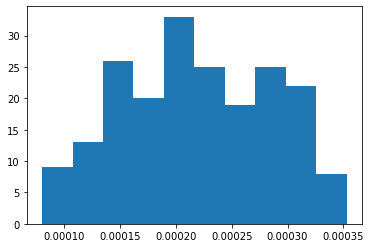

In [7]:
plt.hist([m.PrevTx[2] for m in ms])

In [40]:
shf = find_shifting(src, dat['Pr_Pub_CSI'], cas.DetR / cas.DetR.sum())

shf.P_Dx0

array([0.07843137, 0.07843137, 0.05609835])

In [10]:
valid = []

for cas in ms:
    ex_det = cas.DetR
    ex_det = ex_det / ex_det.sum()
    ex_vis = 2.75
 
    opt = minimize(fn, x0 = x0, args = (shf, ex_det, ex_vis, ), method='SLSQP', bounds=bds)

    if opt.x[1] < 1:
        valid.append((cas, opt.x))


In [11]:
len(valid)

142

In [32]:
Cascade = bind_cascade(shf, cas)

{'R_SelfCure': 0.24569240658469355,
 'R_Die_Asym': 0.1184904667688908,
 'R_Die_Sym': 0.15223817829839217,
 'R_Die_Tx': [0.11764705882352935, 0.02439024390243894, 0.0200989760252006],
 'R_Onset': 2.0529237626466283,
 'R_Aware': 1.832850167338458,
 'R_CSI': 17.046301270925966,
 'R_ReCSI': 15.350455388618132,
 'P_Entry': [0.5165692007797271, 0.17506827672172362, 0.30836252249854923],
 'P_Tr': [[0.5210886295724138, 0.17343162342661222, 0.30547974700097397],
  [0.5027188452628173, 0.1800840057076292, 0.3171971490295535],
  [0.5027188452628173, 0.1800840057076292, 0.3171971490295535]],
 'P_Dx0': [0.0784313725490196, 0.0784313725490196, 0.056098350304051664],
 'P_Dx1': [[0.7481203007518797, 0.7481203007518797, 0.6747064881102688],
  [0.7481203007518797, 0.7481203007518797, 0.6747064881102688],
  [0.14068441064638784, 0.14068441064638784, 0.10259855855128824]],
 'R_Succ_Tx': [2.0, 2.0, 1.6481160340664551],
 'R_LTFU_Tx': [0.11764705882352935, 0.04878048780487788, 0.0602969280756018],
 'PPV': [0